In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, hamming_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
import polars as pl
import plotly.express as px
from sklearn.calibration import CalibratedClassifierCV

## Data Reading and Cleaning

First we needed information from the unmodified dataset in order to get the main categories (not the ones we chose for clustering not very wisely). So we loaded the dataset which contained the embeddings, with a size = 25000 and the big dataset with over 3 million rows. The big dataset was read in polars as it is still faster then pandas,  being written in Rust although pandas 2.0 can somehow compete.

In [2]:
df = pd.read_parquet("arxiv_selected_data.parquet")
df

title   
0       Unravelling Heterogeneous Transport of Endosomes  \
1      Structural Correlates Of Spatial Navigation An...   
2      Assessing the spatio-temporal spread of COVID-...   
3      Revising the global biogeography of plant life...   
4      Improving Maximum Likelihood Difference Scalin...   
...                                                  ...   
24995  Generating Seed magnetic field \`a la Chiral B...   
24996  Designing gate operations for single ion quant...   
24997  Phase stability of entropy stabilized oxides w...   
24998  Life and death in the tails of the GRW wave fu...   
24999  A Distributed Active Perception Strategy for S...   

                                                abstract main_category   
0        A major open problem in biophysics is to und...       biology  \
1        Spatial learning across many species is impa...       biology   
2        The outbreak of COVID-19 in 2020 has led to ...       biology   
3        There are two main life cycles in plants, an...       biology   
4        The goal of most subjective studies is to pl...       biology   
...                                                  ...           ...   
24995    Cosmological and astrophysical observations ...       physics   
24996    Quantum computers based on rare-earth-ion-do...       physics   
24997    The prediction of new high entropy oxides (H...       physics   
24998    It is often assumed that the only effect of ...       physics   
24999    Algorithms for multi-agent systems to locate...       physics   

                                                 context  n_tokens   
0      Unravelling Heterogeneous Transport of Endosom...       226  \
1      Structural Correlates Of Spatial Navigation An...       287   
2      Assessing the spatio-temporal spread of COVID-...       324   
3      Revising the global biogeography of plant life...       292   
4      Improving Maximum Likelihood Difference Scalin...       196   
...                                                  ...       ...   
24995  Generating Seed magnetic field \`a la Chiral B...       269   
24996  Designing gate operations for single ion quant...       220   
24997  Phase stability of entropy stabilized oxides w...       274   
24998  Life and death in the tails of the GRW wave fu...       153   
24999  A Distributed Active Perception Strategy for S...       240   

                                               embedding  
0      [-0.01070667989552021, 0.016570184379816055, -...  
1      [0.00046986134839244187, 0.0246795192360878, 0...  
2      [0.012299922294914722, 0.02555740252137184, 0....  
3      [0.005973129998892546, 0.010254580527544022, 0...  
4      [-0.014093579724431038, 0.03129765763878822, 0...  
...                                                  ...  
24995  [-0.010015178471803665, -0.0012271832674741745...  
24996  [-0.011170969344675541, 0.010891012847423553, ...  
24997  [0.012936733663082123, 0.002311568707227707, -...  
24998  [-0.011646143160760403, 0.010047382675111294, ...  
24999  [0.001964063383638859, 0.025338690727949142, -...  

[25000 rows x 6 columns]

In [3]:

# Read data
df_all = pl.read_ndjson("arxiv.json")
df_all = df_all.to_pandas(use_pyarrow_extension_array=True)
df_all

id           submitter   
0               0704.0001      Pavel Nadolsky  \
1               0704.0002        Louis Theran   
2               0704.0003         Hongjun Pan   
3               0704.0004        David Callan   
4               0704.0005  Alberto Torchinsky   
...                   ...                 ...   
2254193  supr-con/9608008     Ruslan Prozorov   
2254194  supr-con/9609001  Durga P. Choudhury   
2254195  supr-con/9609002  Durga P. Choudhury   
2254196  supr-con/9609003   Hasegawa Yasumasa   
2254197  supr-con/9609004    Masanori Ichioka   

                                                   authors   
0        C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...  \
1                          Ileana Streinu and Louis Theran   
2                                              Hongjun Pan   
3                                             David Callan   
4                 Wael Abu-Shammala and Alberto Torchinsky   
...                                                    ...   
2254193  R. Prozorov, M. Konczykowski, B. Schmidt, Y. Y...   
2254194  Durga P. Choudhury, Balam A. Willemsen, John S...   
2254195  Balam A. Willemsen, J. S. Derov and S.Sridhar ...   
2254196  Yasumasa Hasegawa (Himeji Institute of Technol...   
2254197  Naoki Enomoto, Masanori Ichioka and Kazushige ...   

                                                     title   
0        Calculation of prompt diphoton production cros...  \
1                 Sparsity-certifying Graph Decompositions   
2        The evolution of the Earth-Moon system based o...   
3        A determinant of Stirling cycle numbers counts...   
4        From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...   
...                                                    ...   
2254193  On the origin of the irreversibility line in t...   
2254194  Nonlinear Response of HTSC Thin Film Microwave...   
2254195  Critical State Flux Penetration and Linear Mic...   
2254196  Density of States and NMR Relaxation Rate in A...   
2254197  Ginzburg Landau theory for d-wave pairing and ...   

                                                  comments   
0                  37 pages, 15 figures; published version  \
1                    To appear in Graphs and Combinatorics   
2                                      23 pages, 3 figures   
3                                                 11 pages   
4                                                     <NA>   
...                                                    ...   
2254193  19 pages, LaTex, 6 PostScript figures; Author'...   
2254194  4 pages, LaTeX type, Uses IEEE style files, 60...   
2254195  20 pages, LaTeX type, Uses REVTeX style files,...   
2254196  7 pages, 4 PostScript Figures, LaTeX, to appea...   
2254197  12 pages including 8 eps figs, LaTeX with jpsj...   

                                       journal-ref   
0                         Phys.Rev.D76:013009,2007  \
1                                             <NA>   
2                                             <NA>   
3                                             <NA>   
4        Illinois J. Math. 52 (2008) no.2, 681-689   
...                                            ...   
2254193                                       <NA>   
2254194                                       <NA>   
2254195                                       <NA>   
2254196                                       <NA>   
2254197         J. Phys. Soc. Jpn. 66, 204 (1997).   

                                doi         report-no   
0        10.1103/PhysRevD.76.013009  ANL-HEP-PR-07-12  \
1                              <NA>              <NA>   
2                              <NA>              <NA>   
3                              <NA>              <NA>   
4                              <NA>              <NA>   
...                             ...               ...   
2254193   10.1103/PhysRevB.54.15530              <NA>   
2254194           10.1109/77.620744              <NA>   
2254195   10.1103/PhysRevB.56.11989  

In [4]:
df = df.merge(df_all[["categories", "abstract", "title"]], how="left", on=["title", "abstract"] )
df

title   
0       Unravelling Heterogeneous Transport of Endosomes  \
1      Structural Correlates Of Spatial Navigation An...   
2      Assessing the spatio-temporal spread of COVID-...   
3      Revising the global biogeography of plant life...   
4      Improving Maximum Likelihood Difference Scalin...   
...                                                  ...   
24996  Generating Seed magnetic field \`a la Chiral B...   
24997  Designing gate operations for single ion quant...   
24998  Phase stability of entropy stabilized oxides w...   
24999  Life and death in the tails of the GRW wave fu...   
25000  A Distributed Active Perception Strategy for S...   

                                                abstract main_category   
0        A major open problem in biophysics is to und...       biology  \
1        Spatial learning across many species is impa...       biology   
2        The outbreak of COVID-19 in 2020 has led to ...       biology   
3        There are two main life cycles in plants, an...       biology   
4        The goal of most subjective studies is to pl...       biology   
...                                                  ...           ...   
24996    Cosmological and astrophysical observations ...       physics   
24997    Quantum computers based on rare-earth-ion-do...       physics   
24998    The prediction of new high entropy oxides (H...       physics   
24999    It is often assumed that the only effect of ...       physics   
25000    Algorithms for multi-agent systems to locate...       physics   

                                                 context  n_tokens   
0      Unravelling Heterogeneous Transport of Endosom...       226  \
1      Structural Correlates Of Spatial Navigation An...       287   
2      Assessing the spatio-temporal spread of COVID-...       324   
3      Revising the global biogeography of plant life...       292   
4      Improving Maximum Likelihood Difference Scalin...       196   
...                                                  ...       ...   
24996  Generating Seed magnetic field \`a la Chiral B...       269   
24997  Designing gate operations for single ion quant...       220   
24998  Phase stability of entropy stabilized oxides w...       274   
24999  Life and death in the tails of the GRW wave fu...       153   
25000  A Distributed Active Perception Strategy for S...       240   

                                               embedding   
0      [-0.01070667989552021, 0.016570184379816055, -...  \
1      [0.00046986134839244187, 0.0246795192360878, 0...   
2      [0.012299922294914722, 0.02555740252137184, 0....   
3      [0.005973129998892546, 0.010254580527544022, 0...   
4      [-0.014093579724431038, 0.03129765763878822, 0...   
...                                                  ...   
24996  [-0.010015178471803665, -0.0012271832674741745...   
24997  [-0.011170969344675541, 0.010891012847423553, ...   
24998  [0.012936733663082123, 0.002311568707227707, -...   
24999  [-0.011646143160760403, 0.010047382675111294, ...   
25000  [0.001964063383638859, 0.025338690727949142, -...   

                              categories  
0                 q-bio.SC cond-mat.soft  
1                               q-bio.NC  
2                q-bio.PE physics.soc-ph  
3                               q-bio.PE  
4                         q-bio.NC cs.LG  
...                                  ...  
24996     astro-ph.CO astro-ph.HE hep-ph  
24997                           quant-ph  
24998  cond-mat.mtrl-sci cond-mat.dis-nn  
24999                           quant-ph  
25000                      eess.SY cs.SY  

[25001 rows x 7 columns]

The next step was to do a merge on the columns that we haven't dropped in the previous homework. Those two were the abstract and the title. Then we verified to not have any null values and using pandas we constructed more reliable categories then before (a total of 20) ranging from computer science to physics matemathics and economics. 

In [130]:
df = df[df.notnull()]
df

title   
0       Unravelling Heterogeneous Transport of Endosomes  \
1      Structural Correlates Of Spatial Navigation An...   
2      Assessing the spatio-temporal spread of COVID-...   
3      Revising the global biogeography of plant life...   
4      Improving Maximum Likelihood Difference Scalin...   
...                                                  ...   
24996  Generating Seed magnetic field \`a la Chiral B...   
24997  Designing gate operations for single ion quant...   
24998  Phase stability of entropy stabilized oxides w...   
24999  Life and death in the tails of the GRW wave fu...   
25000  A Distributed Active Perception Strategy for S...   

                                                abstract   
0        A major open problem in biophysics is to und...  \
1        Spatial learning across many species is impa...   
2        The outbreak of COVID-19 in 2020 has led to ...   
3        There are two main life cycles in plants, an...   
4        The goal of most subjective studies is to pl...   
...                                                  ...   
24996    Cosmological and astrophysical observations ...   
24997    Quantum computers based on rare-earth-ion-do...   
24998    The prediction of new high entropy oxides (H...   
24999    It is often assumed that the only effect of ...   
25000    Algorithms for multi-agent systems to locate...   

                                                 context  n_tokens   
0      Unravelling Heterogeneous Transport of Endosom...       226  \
1      Structural Correlates Of Spatial Navigation An...       287   
2      Assessing the spatio-temporal spread of COVID-...       324   
3      Revising the global biogeography of plant life...       292   
4      Improving Maximum Likelihood Difference Scalin...       196   
...                                                  ...       ...   
24996  Generating Seed magnetic field \`a la Chiral B...       269   
24997  Designing gate operations for single ion quant...       220   
24998  Phase stability of entropy stabilized oxides w...       274   
24999  Life and death in the tails of the GRW wave fu...       153   
25000  A Distributed Active Perception Strategy for S...       240   

                                               embedding   
0      [-0.01070667989552021, 0.016570184379816055, -...  \
1      [0.00046986134839244187, 0.0246795192360878, 0...   
2      [0.012299922294914722, 0.02555740252137184, 0....   
3      [0.005973129998892546, 0.010254580527544022, 0...   
4      [-0.014093579724431038, 0.03129765763878822, 0...   
...                                                  ...   
24996  [-0.010015178471803665, -0.0012271832674741745...   
24997  [-0.011170969344675541, 0.010891012847423553, ...   
24998  [0.012936733663082123, 0.002311568707227707, -...   
24999  [-0.011646143160760403, 0.010047382675111294, ...   
25000  [0.001964063383638859, 0.025338690727949142, -...   

                              categories  
0                 q-bio.SC cond-mat.soft  
1                               q-bio.NC  
2                q-bio.PE physics.soc-ph  
3                               q-bio.PE  
4                         q-bio.NC cs.LG  
...                                  ...  
24996     astro-ph.CO astro-ph.HE hep-ph  
24997                           quant-ph  
24998  cond-mat.mtrl-sci cond-mat.dis-nn  
24999                           quant-ph  
25000                      eess.SY cs.SY  

[25001 rows x 6 columns]

In [5]:
df.drop(columns = ["main_category"], inplace=True)
df

title   
0       Unravelling Heterogeneous Transport of Endosomes  \
1      Structural Correlates Of Spatial Navigation An...   
2      Assessing the spatio-temporal spread of COVID-...   
3      Revising the global biogeography of plant life...   
4      Improving Maximum Likelihood Difference Scalin...   
...                                                  ...   
24996  Generating Seed magnetic field \`a la Chiral B...   
24997  Designing gate operations for single ion quant...   
24998  Phase stability of entropy stabilized oxides w...   
24999  Life and death in the tails of the GRW wave fu...   
25000  A Distributed Active Perception Strategy for S...   

                                                abstract   
0        A major open problem in biophysics is to und...  \
1        Spatial learning across many species is impa...   
2        The outbreak of COVID-19 in 2020 has led to ...   
3        There are two main life cycles in plants, an...   
4        The goal of most subjective studies is to pl...   
...                                                  ...   
24996    Cosmological and astrophysical observations ...   
24997    Quantum computers based on rare-earth-ion-do...   
24998    The prediction of new high entropy oxides (H...   
24999    It is often assumed that the only effect of ...   
25000    Algorithms for multi-agent systems to locate...   

                                                 context  n_tokens   
0      Unravelling Heterogeneous Transport of Endosom...       226  \
1      Structural Correlates Of Spatial Navigation An...       287   
2      Assessing the spatio-temporal spread of COVID-...       324   
3      Revising the global biogeography of plant life...       292   
4      Improving Maximum Likelihood Difference Scalin...       196   
...                                                  ...       ...   
24996  Generating Seed magnetic field \`a la Chiral B...       269   
24997  Designing gate operations for single ion quant...       220   
24998  Phase stability of entropy stabilized oxides w...       274   
24999  Life and death in the tails of the GRW wave fu...       153   
25000  A Distributed Active Perception Strategy for S...       240   

                                               embedding   
0      [-0.01070667989552021, 0.016570184379816055, -...  \
1      [0.00046986134839244187, 0.0246795192360878, 0...   
2      [0.012299922294914722, 0.02555740252137184, 0....   
3      [0.005973129998892546, 0.010254580527544022, 0...   
4      [-0.014093579724431038, 0.03129765763878822, 0...   
...                                                  ...   
24996  [-0.010015178471803665, -0.0012271832674741745...   
24997  [-0.011170969344675541, 0.010891012847423553, ...   
24998  [0.012936733663082123, 0.002311568707227707, -...   
24999  [-0.011646143160760403, 0.010047382675111294, ...   
25000  [0.001964063383638859, 0.025338690727949142, -...   

                              categories  
0                 q-bio.SC cond-mat.soft  
1                               q-bio.NC  
2                q-bio.PE physics.soc-ph  
3                               q-bio.PE  
4                         q-bio.NC cs.LG  
...                                  ...  
24996     astro-ph.CO astro-ph.HE hep-ph  
24997                           quant-ph  
24998  cond-mat.mtrl-sci cond-mat.dis-nn  
24999                           quant-ph  
25000                      eess.SY cs.SY  

[25001 rows x 6 columns]

In [6]:
df["categories"] = df["categories"].str.split(' ')
df

title   
0       Unravelling Heterogeneous Transport of Endosomes  \
1      Structural Correlates Of Spatial Navigation An...   
2      Assessing the spatio-temporal spread of COVID-...   
3      Revising the global biogeography of plant life...   
4      Improving Maximum Likelihood Difference Scalin...   
...                                                  ...   
24996  Generating Seed magnetic field \`a la Chiral B...   
24997  Designing gate operations for single ion quant...   
24998  Phase stability of entropy stabilized oxides w...   
24999  Life and death in the tails of the GRW wave fu...   
25000  A Distributed Active Perception Strategy for S...   

                                                abstract   
0        A major open problem in biophysics is to und...  \
1        Spatial learning across many species is impa...   
2        The outbreak of COVID-19 in 2020 has led to ...   
3        There are two main life cycles in plants, an...   
4        The goal of most subjective studies is to pl...   
...                                                  ...   
24996    Cosmological and astrophysical observations ...   
24997    Quantum computers based on rare-earth-ion-do...   
24998    The prediction of new high entropy oxides (H...   
24999    It is often assumed that the only effect of ...   
25000    Algorithms for multi-agent systems to locate...   

                                                 context  n_tokens   
0      Unravelling Heterogeneous Transport of Endosom...       226  \
1      Structural Correlates Of Spatial Navigation An...       287   
2      Assessing the spatio-temporal spread of COVID-...       324   
3      Revising the global biogeography of plant life...       292   
4      Improving Maximum Likelihood Difference Scalin...       196   
...                                                  ...       ...   
24996  Generating Seed magnetic field \`a la Chiral B...       269   
24997  Designing gate operations for single ion quant...       220   
24998  Phase stability of entropy stabilized oxides w...       274   
24999  Life and death in the tails of the GRW wave fu...       153   
25000  A Distributed Active Perception Strategy for S...       240   

                                               embedding   
0      [-0.01070667989552021, 0.016570184379816055, -...  \
1      [0.00046986134839244187, 0.0246795192360878, 0...   
2      [0.012299922294914722, 0.02555740252137184, 0....   
3      [0.005973129998892546, 0.010254580527544022, 0...   
4      [-0.014093579724431038, 0.03129765763878822, 0...   
...                                                  ...   
24996  [-0.010015178471803665, -0.0012271832674741745...   
24997  [-0.011170969344675541, 0.010891012847423553, ...   
24998  [0.012936733663082123, 0.002311568707227707, -...   
24999  [-0.011646143160760403, 0.010047382675111294, ...   
25000  [0.001964063383638859, 0.025338690727949142, -...   

                                    categories  
0                 ['q-bio.SC' 'cond-mat.soft']  
1                                 ['q-bio.NC']  
2                ['q-bio.PE' 'physics.soc-ph']  
3                                 ['q-bio.PE']  
4                         ['q-bio.NC' 'cs.LG']  
...                                        ...  
24996   ['astro-ph.CO' 'astro-ph.HE' 'hep-ph']  
24997                             ['quant-ph']  
24998  ['cond-mat.mtrl-sci' 'cond-mat.dis-nn']  
24999                             ['quant-ph']  
25000                      ['eess.SY' 'cs.SY']  

[25001 rows x 6 columns]

In [7]:
df['main_category'] = df["categories"].apply(lambda x:[a.split('.')[0] for a in x])
df

title   
0       Unravelling Heterogeneous Transport of Endosomes  \
1      Structural Correlates Of Spatial Navigation An...   
2      Assessing the spatio-temporal spread of COVID-...   
3      Revising the global biogeography of plant life...   
4      Improving Maximum Likelihood Difference Scalin...   
...                                                  ...   
24996  Generating Seed magnetic field \`a la Chiral B...   
24997  Designing gate operations for single ion quant...   
24998  Phase stability of entropy stabilized oxides w...   
24999  Life and death in the tails of the GRW wave fu...   
25000  A Distributed Active Perception Strategy for S...   

                                                abstract   
0        A major open problem in biophysics is to und...  \
1        Spatial learning across many species is impa...   
2        The outbreak of COVID-19 in 2020 has led to ...   
3        There are two main life cycles in plants, an...   
4        The goal of most subjective studies is to pl...   
...                                                  ...   
24996    Cosmological and astrophysical observations ...   
24997    Quantum computers based on rare-earth-ion-do...   
24998    The prediction of new high entropy oxides (H...   
24999    It is often assumed that the only effect of ...   
25000    Algorithms for multi-agent systems to locate...   

                                                 context  n_tokens   
0      Unravelling Heterogeneous Transport of Endosom...       226  \
1      Structural Correlates Of Spatial Navigation An...       287   
2      Assessing the spatio-temporal spread of COVID-...       324   
3      Revising the global biogeography of plant life...       292   
4      Improving Maximum Likelihood Difference Scalin...       196   
...                                                  ...       ...   
24996  Generating Seed magnetic field \`a la Chiral B...       269   
24997  Designing gate operations for single ion quant...       220   
24998  Phase stability of entropy stabilized oxides w...       274   
24999  Life and death in the tails of the GRW wave fu...       153   
25000  A Distributed Active Perception Strategy for S...       240   

                                               embedding   
0      [-0.01070667989552021, 0.016570184379816055, -...  \
1      [0.00046986134839244187, 0.0246795192360878, 0...   
2      [0.012299922294914722, 0.02555740252137184, 0....   
3      [0.005973129998892546, 0.010254580527544022, 0...   
4      [-0.014093579724431038, 0.03129765763878822, 0...   
...                                                  ...   
24996  [-0.010015178471803665, -0.0012271832674741745...   
24997  [-0.011170969344675541, 0.010891012847423553, ...   
24998  [0.012936733663082123, 0.002311568707227707, -...   
24999  [-0.011646143160760403, 0.010047382675111294, ...   
25000  [0.001964063383638859, 0.025338690727949142, -...   

                                    categories                 main_category  
0                 ['q-bio.SC' 'cond-mat.soft']             [q-bio, cond-mat]  
1                                 ['q-bio.NC']                       [q-bio]  
2                ['q-bio.PE' 'physics.soc-ph']              [q-bio, physics]  
3                                 ['q-bio.PE']                       [q-bio]  
4                         ['q-bio.NC' 'cs.LG']                   [q-bio, cs]  
...                                        ...                           ...  
24996   ['astro-ph.CO' 'astro-ph.HE' 'hep-ph']  [astro-ph, astro-ph, hep-ph]  
24997                             ['quant-ph']                    [quant-ph]  
24998  ['cond-mat.mtrl-sci' 'cond-mat.dis-nn']          [cond-mat, cond-mat]  
24999                             ['quant-ph']                    [quant-ph]  
25000                      ['eess.SY' 'cs.SY']                    [eess, cs]  

[25001 rows x 7 columns]

Now we know that we have a multi-label classification problem. So in order to clasify correctly we need to use a MultiLabel Binarizer which basically makes columns and for a row, each label it has will be in the mapped column with the value of 1. After we made the Binarizer we appended it to the rest of the dataset.

In [9]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df["main_category"])
labels

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [10]:
df = pd.concat([df, pd.DataFrame(labels)], axis= 1)
df.columns = ["title", "abstract", "context", "n_tokens", "embedding", "categories", "main_category"] + list(mlb.classes_)
df

title   
0       Unravelling Heterogeneous Transport of Endosomes  \
1      Structural Correlates Of Spatial Navigation An...   
2      Assessing the spatio-temporal spread of COVID-...   
3      Revising the global biogeography of plant life...   
4      Improving Maximum Likelihood Difference Scalin...   
...                                                  ...   
24996  Generating Seed magnetic field \`a la Chiral B...   
24997  Designing gate operations for single ion quant...   
24998  Phase stability of entropy stabilized oxides w...   
24999  Life and death in the tails of the GRW wave fu...   
25000  A Distributed Active Perception Strategy for S...   

                                                abstract   
0        A major open problem in biophysics is to und...  \
1        Spatial learning across many species is impa...   
2        The outbreak of COVID-19 in 2020 has led to ...   
3        There are two main life cycles in plants, an...   
4        The goal of most subjective studies is to pl...   
...                                                  ...   
24996    Cosmological and astrophysical observations ...   
24997    Quantum computers based on rare-earth-ion-do...   
24998    The prediction of new high entropy oxides (H...   
24999    It is often assumed that the only effect of ...   
25000    Algorithms for multi-agent systems to locate...   

                                                 context  n_tokens   
0      Unravelling Heterogeneous Transport of Endosom...       226  \
1      Structural Correlates Of Spatial Navigation An...       287   
2      Assessing the spatio-temporal spread of COVID-...       324   
3      Revising the global biogeography of plant life...       292   
4      Improving Maximum Likelihood Difference Scalin...       196   
...                                                  ...       ...   
24996  Generating Seed magnetic field \`a la Chiral B...       269   
24997  Designing gate operations for single ion quant...       220   
24998  Phase stability of entropy stabilized oxides w...       274   
24999  Life and death in the tails of the GRW wave fu...       153   
25000  A Distributed Active Perception Strategy for S...       240   

                                               embedding   
0      [-0.01070667989552021, 0.016570184379816055, -...  \
1      [0.00046986134839244187, 0.0246795192360878, 0...   
2      [0.012299922294914722, 0.02555740252137184, 0....   
3      [0.005973129998892546, 0.010254580527544022, 0...   
4      [-0.014093579724431038, 0.03129765763878822, 0...   
...                                                  ...   
24996  [-0.010015178471803665, -0.0012271832674741745...   
24997  [-0.011170969344675541, 0.010891012847423553, ...   
24998  [0.012936733663082123, 0.002311568707227707, -...   
24999  [-0.011646143160760403, 0.010047382675111294, ...   
25000  [0.001964063383638859, 0.025338690727949142, -...   

                                    categories                 main_category   
0                 ['q-bio.SC' 'cond-mat.soft']             [q-bio, cond-mat]  \
1                                 ['q-bio.NC']                       [q-bio]   
2                ['q-bio.PE' 'physics.soc-ph']              [q-bio, physics]   
3                                 ['q-bio.PE']                       [q-bio]   
4                         ['q-bio.NC' 'cs.LG']                   [q-bio, cs]   
...                                        ...                           ...   
24996   ['astro-ph.CO' 'astro-ph.HE' 'hep-ph']  [astro-ph, astro-ph, hep-ph]   
24997                             ['quant-ph']                    [quant-ph]   
24998  ['cond-mat.mtrl-sci' 'cond-mat.dis-nn']          [cond-mat, cond-mat]   
24999                             ['quant-ph']                    [quant-ph]   
25000                      ['eess.SY' 'cs.SY']                    [eess, cs]   

       astro-ph  cond-mat  cs  ...  math  math-ph  nlin  nucl-ex  nucl-th   
0        

Here we wanted to see if we have categories that only have 1 assosciated row. This is because we need at least two rows in order to make a prediction.

In [11]:
sample_df = df.sample(frac = 1, random_state = 4)
keep = sample_df.iloc[:,7:].apply(sum) > 1
sample_df = pd.concat([sample_df.iloc[:,:7],sample_df.iloc[:,7:].iloc[:,keep.values]], axis = 1)

categories = sample_df.columns[7:]

# removed categories
print('Removed following categories from training : {}'.format(str(keep[~keep].index.to_list())))

Removed following categories from training : []


## EDA

Now we want to make some visual plots to understand the data better. First we wanted to see how much bias does our data have. If you have read arxiv articles before you may know that a lot of articles(and the most read) come from the computer science main category. So we made a distributions plot where we see that the most predominant categories are Computer Science, Maths and Quantitative biology. They compose aproximately 1/2 of our dataset.

In [12]:
import altair as alt
source = pd.DataFrame(df.iloc[:,7:].apply(sum)).reset_index().rename(columns = {0:'count'})
ptotalText = alt.Text('PercentOfTotal:Q', format = '.2%')

chart = alt.Chart(source).transform_joinaggregate(
    TotalPapers='sum(count)',
).transform_calculate(
    PercentOfTotal="datum.count / datum.TotalPapers"
).mark_bar().encode(
    x = 'index',
    y = 'count',
    tooltip = ['index','count', ptotalText]
).properties(
    title='Sample of arXiv Papers by Category, after 2020-01-01',
    width = 800
)

chart = chart + chart.mark_text(
    align='center',
    baseline='middle',
    dx= 3,  
    dy = -5
).encode(
    text = ptotalText
) 

chart

alt.LayerChart(...)

In [13]:
embedding_cleaned = np.nan_to_num(df['embedding'])
embedding_cleaned = np.vstack(embedding_cleaned)
embedding_cleaned



array([[-0.01070668,  0.01657018, -0.00108155, ..., -0.02059709,
        -0.00134344, -0.01858364],
       [ 0.00046986,  0.02467952,  0.03012411, ..., -0.01617482,
        -0.03057452, -0.02824301],
       [ 0.01229992,  0.0255574 ,  0.01366208, ..., -0.00078645,
        -0.01801831, -0.02265775],
       ...,
       [ 0.01293673,  0.00231157, -0.0156878 , ...,  0.00557259,
        -0.00598861, -0.02414231],
       [-0.01164614,  0.01004738,  0.01947456, ..., -0.00048583,
         0.00926179, -0.01612543],
       [ 0.00196406,  0.02533869, -0.00946528, ..., -0.01706969,
        -0.02455517, -0.02265231]])

Now we are going to do two data visualization methods. First, we will do a t-Distributed Stochastic Embedding and 
after that the classical Principal Component Analysis. With PCA we will also reduce the dimensionality of our dataset to 300, but still not escaping from the dimensionaity curse proportion.

In [14]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(embedding_cleaned)
vis_dims.shape

(25001, 2)

In [15]:
mlb.classes_

array(['astro-ph', 'cond-mat', 'cs', 'econ', 'eess', 'gr-qc', 'hep-ex',
       'hep-lat', 'hep-ph', 'hep-th', 'math', 'math-ph', 'nlin',
       'nucl-ex', 'nucl-th', 'physics', 'q-bio', 'q-fin', 'quant-ph',
       'stat'], dtype=object)

In [20]:
df["main_category"][0]

['q-bio', 'cond-mat']

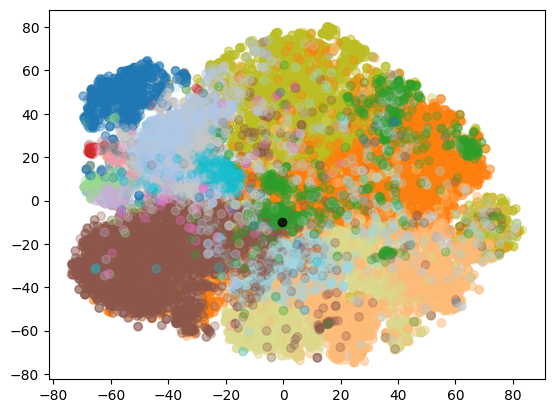

In [38]:
labels = ['astro-ph', 'cond-mat', 'cs', 'econ', 'eess', 'gr-qc', 'hep-ex',
       'hep-lat', 'hep-ph', 'hep-th', 'math', 'math-ph', 'nlin',
       'nucl-ex', 'nucl-th', 'physics', 'q-bio', 'q-fin', 'quant-ph',
       'stat']

label_to_color_index = {label: i for i, label in enumerate(labels)}
color_indices = df['main_category'].apply(lambda cats: label_to_color_index[cats[0]])



colormap = plt.get_cmap('tab20')
colors = colormap(color_indices)
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

plt.scatter(x[:25001], y[:25001], c=colors, alpha=0.3)
plt.scatter(x[-1:], y[-1:], c="black", alpha=0.8)


plt.show()

In [32]:
color_indices

0        16
1        16
2        16
3        16
4        16
         ..
24996     0
24997    18
24998     1
24999    18
25000     4
Name: main_category, Length: 25001, dtype: int64

In [64]:
pca = PCA(n_components=2).fit(embedding_cleaned)
data2D = pd.DataFrame(pca.transform(embedding_cleaned), columns=['PC1', 'PC2'])

# Get categories for abstracts
color = df.iloc[:, 7:].apply(lambda x: x.index[x > 0][0], axis=1)
data2D['main_category'] = color.to_list()
alt.data_transformers.enable('default', max_rows=None)
# Plot scatter plot 
alt.Chart(data2D).mark_circle(size=15).encode(
    x=alt.X('PC1', axis=None),
    y=alt.Y('PC2', axis=None),
    color='main_category'
).properties(
    title='First 2 Principal Components of the arXiv TF-IDF Matrix by Category',
    width=600,
    height=600
).configure_axis(
    grid=False
).configure_view(strokeOpacity=0)

alt.Chart(...)

In [41]:

flat_colors = np.array(colors[:24999]).ravel()
pca = PCA(n_components = 2, random_state = 0)

pca_data = pca.fit_transform(embedding_cleaned)
print(pca.explained_variance_ratio_.sum())
#print(pd.DataFrame(pca.components_, columns = cols))


pca = PCA(n_components = 3, random_state = 0)

pca_data = pca.fit_transform(embedding_cleaned)
print(pca.explained_variance_ratio_.sum())
total_var = pca.explained_variance_ratio_.sum()*100
fig = px.scatter_3d(pca_data, x = 0, y=  1, z = 2, color = color_indices,
                    title = f"Total explained variance: {total_var:.2f}%",
                    labels = {"0": "PC1", "1": "PC2", "2": "PC3"})
fig.show()

0.088197685595682
0.11744953092685427


In [42]:
pca = PCA(n_components = 100, random_state = 0)

pca_data = pca.fit_transform(embedding_cleaned[:24999])
print(pca.explained_variance_ratio_.sum())

pca = PCA(n_components = 200, random_state = 0)

pca_data = pca.fit_transform(embedding_cleaned[:24999])
print(pca.explained_variance_ratio_.sum())

pca = PCA(n_components = 250, random_state = 0)

pca_data = pca.fit_transform(embedding_cleaned[:24999])
print(pca.explained_variance_ratio_.sum())



pca = PCA(n_components = 300, random_state = 0)

pca_data = pca.fit_transform(embedding_cleaned[:24999])
print(pca.explained_variance_ratio_.sum())

0.5962666199653739
0.746828652203751
0.7938629584794364
0.8307113882821076


As we can see both data visualization methods could make "clusterings" of our data. Because the Pipeline function does not let us use t-SNE for dimensionality reduction, one of the main reasons being that it does not keep the dimensionality of the data, we will use a 300 components PCA, because it explains over 80 % of our data, which should be enough.


In [78]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(df["main_category"])

X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), y_train, test_size=0.2, random_state=42
)



In [47]:
categories = df.columns[7:]
categories

Index(['astro-ph', 'cond-mat', 'cs', 'econ', 'eess', 'gr-qc', 'hep-ex',
       'hep-lat', 'hep-ph', 'hep-th', 'math', 'math-ph', 'nlin', 'nucl-ex',
       'nucl-th', 'physics', 'q-bio', 'q-fin', 'quant-ph', 'stat'],
      dtype='object')

In [74]:
df["main_category"]

0                   [q-bio, cond-mat]
1                             [q-bio]
2                    [q-bio, physics]
3                             [q-bio]
4                         [q-bio, cs]
                     ...             
24996    [astro-ph, astro-ph, hep-ph]
24997                      [quant-ph]
24998            [cond-mat, cond-mat]
24999                      [quant-ph]
25000                      [eess, cs]
Name: main_category, Length: 25001, dtype: object

## Calibration Classifier 
Calibrating a classifier consists of fitting a regressor (called a calibrator) that maps the output of the classifier (as given by decision_function or predict_proba) to a calibrated probability in [0, 1]
The samples that are used to fit the calibrator should not be the same samples used to fit the classifier, as this would introduce bias. This is because performance of the classifier on its training data would be better than for novel data. Using the classifier output of training data to fit the calibrator would thus result in a biased calibrator that maps to probabilities closer to 0 and 1 than it should.

CalibratedClassifierCV uses a cross-validation approach to ensure unbiased data is always used to fit the calibrator. The data is split into k (train_set, test_set) couples (as determined by cv). When ensemble=True (default), the following procedure is repeated independently for each cross-validation split: a clone of base_estimator is first trained on the train subset. Then its predictions on the test subset are used to fit a calibrator (either a sigmoid or isotonic regressor). This results in an ensemble of k (classifier, calibrator) couples where each calibrator maps the output of its corresponding classifier into [0, 1]. Each couple is exposed in the calibrated_classifiers_ attribute, where each entry is a calibrated classifier with a predict_proba method that outputs calibrated probabilities. The output of predict_proba for the main CalibratedClassifierCV instance corresponds to the average of the predicted probabilities of the k estimators in the calibrated_classifiers_ list. The output of predict is the class that has the highest probability.

## Random Forests

In random forests (see RandomForestClassifier and RandomForestRegressor classes), each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.

Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size max_features. (See the parameter tuning guidelines for more details).

The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

## Receiver operating characteristic (ROC)

The function roc_curve computes the receiver operating characteristic curve, or ROC curve. Quoting Wikipedia :

“A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.”

This function requires the true binary value and the target scores, which can either be probability estimates of the positive class, confidence values, or binary decisions. 

Compared to metrics such as the subset accuracy, the Hamming loss, or the F1 score, ROC doesn’t require optimizing a threshold for each label.

The roc_auc_score function, denoted by ROC-AUC or AUROC, computes the area under the ROC curve. By doing so, the curve information is summarized in one number.


In [128]:

classifier = CalibratedClassifierCV(RandomForestClassifier(class_weight="balanced", n_jobs=-1, n_estimators= 500, random_state=42))

models = {}
preds = {}

for i, category in enumerate(mlb.classes_):
    pipeline = Pipeline([
        (f'pca_{category}', PCA(n_components=300, random_state=42)),
        (f'clf_{category}', OneVsRestClassifier(classifier, n_jobs=-1)),
    ])
    print('... Processing {}'.format(category))
    pipeline.fit(X_train, y_train[:, i])
    models[category] = pipeline
    prediction = pipeline.predict(X_test)
    preds[category] = prediction
    accuracy = accuracy_score(y_test[:, i], prediction)
    probas_ = pipeline.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test[:, i], probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Accuracy: {} . Area under the ROC curve: {}".format(round(accuracy, 4), round(roc_auc, 4)))
    print()
    

... Processing astro-ph
Accuracy: 0.9908 . Area under the ROC curve: 0.9981

... Processing cond-mat
Accuracy: 0.965 . Area under the ROC curve: 0.9704

... Processing cs
Accuracy: 0.881 . Area under the ROC curve: 0.9441

... Processing econ
Accuracy: 0.9546 . Area under the ROC curve: 0.9827

... Processing eess
Accuracy: 0.9494 . Area under the ROC curve: 0.9453

... Processing gr-qc
Accuracy: 0.9904 . Area under the ROC curve: 0.9814

... Processing hep-ex
Accuracy: 0.9976 . Area under the ROC curve: 0.998

... Processing hep-lat
Accuracy: 0.9986 . Area under the ROC curve: 0.9936

... Processing hep-ph
Accuracy: 0.993 . Area under the ROC curve: 0.9618

... Processing hep-th
Accuracy: 0.9904 . Area under the ROC curve: 0.9932

... Processing math
Accuracy: 0.9086 . Area under the ROC curve: 0.9465

... Processing math-ph
Accuracy: 0.9914 . Area under the ROC curve: 0.9135

... Processing nlin
Accuracy: 0.9862 . Area under the ROC curve: 0.9438

... Processing nucl-ex
Accuracy: 0.9

After we fitted the model it is time to save it in our folder in order to reuse it at times. We will do this by creating a joblib file for each 

In [143]:
import joblib
classifier = RandomForestClassifier(class_weight="balanced", n_jobs=-1, n_estimators=500, random_state=42)

models = {}
preds = {}

for i, category in enumerate(mlb.classes_):
    pipeline = Pipeline([
        (f'pca_{category}', PCA(n_components=300, random_state=42)),
        (f'clf_{category}', OneVsRestClassifier(classifier, n_jobs=-1)),
    ])
    print('... Processing {}'.format(category))
    pipeline.fit(X_train, y_train[:, i])
    models[category] = pipeline
    prediction = pipeline.predict(X_test)
    preds[category] = prediction
    accuracy = accuracy_score(y_test[:, i], prediction)
    probas_ = pipeline.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test[:, i], probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Accuracy: {} . Area under the ROC curve: {}".format(round(accuracy, 4), round(roc_auc, 4)))
    print()

for category, model in models.items():
    filename = f'model_rfc_{category}.joblib'
    joblib.dump(model, filename)

... Processing astro-ph
Accuracy: 0.9844 . Area under the ROC curve: 0.9981

... Processing cond-mat
Accuracy: 0.9572 . Area under the ROC curve: 0.9681

... Processing cs
Accuracy: 0.8604 . Area under the ROC curve: 0.9428

... Processing econ
Accuracy: 0.9088 . Area under the ROC curve: 0.9822

... Processing eess
Accuracy: 0.9398 . Area under the ROC curve: 0.9447

... Processing gr-qc
Accuracy: 0.9874 . Area under the ROC curve: 0.9819

... Processing hep-ex
Accuracy: 0.997 . Area under the ROC curve: 0.9977

... Processing hep-lat
Accuracy: 0.9984 . Area under the ROC curve: 0.9681

... Processing hep-ph
Accuracy: 0.9932 . Area under the ROC curve: 0.9685

... Processing hep-th
Accuracy: 0.9858 . Area under the ROC curve: 0.9933

... Processing math
Accuracy: 0.8946 . Area under the ROC curve: 0.9458

... Processing math-ph
Accuracy: 0.9918 . Area under the ROC curve: 0.8946

... Processing nlin
Accuracy: 0.9862 . Area under the ROC curve: 0.9432

... Processing nucl-ex
Accuracy: 

In [158]:
classifier = GradientBoostingClassifier(n_estimators=500, random_state=42)

models = {}
preds = {}

for i, category in enumerate(mlb.classes_):
    pipeline = Pipeline([
        (f'pca_{category}', PCA(n_components=300, random_state=42)),
        (f'clf_{category}', OneVsRestClassifier(classifier, n_jobs=-1)),
    ])
    print('... Processing {}'.format(category))
    pipeline.fit(X_train, y_train[:, i])
    models[category] = pipeline
    prediction = pipeline.predict(X_test)
    preds[category] = prediction
    accuracy = accuracy_score(y_test[:, i], prediction)
    probas_ = pipeline.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test[:, i], probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Accuracy: {} . Area under the ROC curve: {}".format(round(accuracy, 4), round(roc_auc, 4)))
    print()

for category, model in models.items():
    filename = f'model_gbc_{category}.joblib'
    joblib.dump(model, filename)

... Processing astro-ph


## What are Vector Embeddings?

Vector embeddings are one of the most fascinating and useful concepts in machine learning. They are central to many NLP, recommendation, and search algorithms. If you’ve ever used things like recommendation engines, voice assistants, language translators, you’ve come across systems that rely on embeddings.

ML algorithms, like most software algorithms, need numbers to work with. Sometimes we have a dataset with columns of numeric values or values that can be translated into them (ordinal, categorical, etc). Other times we come across something more abstract like an entire document of text. We create vector embeddings, which are just lists of numbers, for data like this to perform various operations with them. A whole paragraph of text or any other object can be reduced to a vector. Even numerical data can be turned into vectors for easier operations.

ut there is something special about vectors that makes them so useful. This representation makes it possible to translate semantic similarity as perceived by humans to proximity in a vector space.

In other words, when we represent real-world objects and concepts such as images, audio recordings, news articles, user profiles, weather patterns, and political views as vector embeddings, the semantic similarity of these objects and concepts can be quantified by how close they are to each other as points in vector spaces. Vector embedding representations are thus suitable for common machine learning tasks such as clustering, recommendation, and classification.

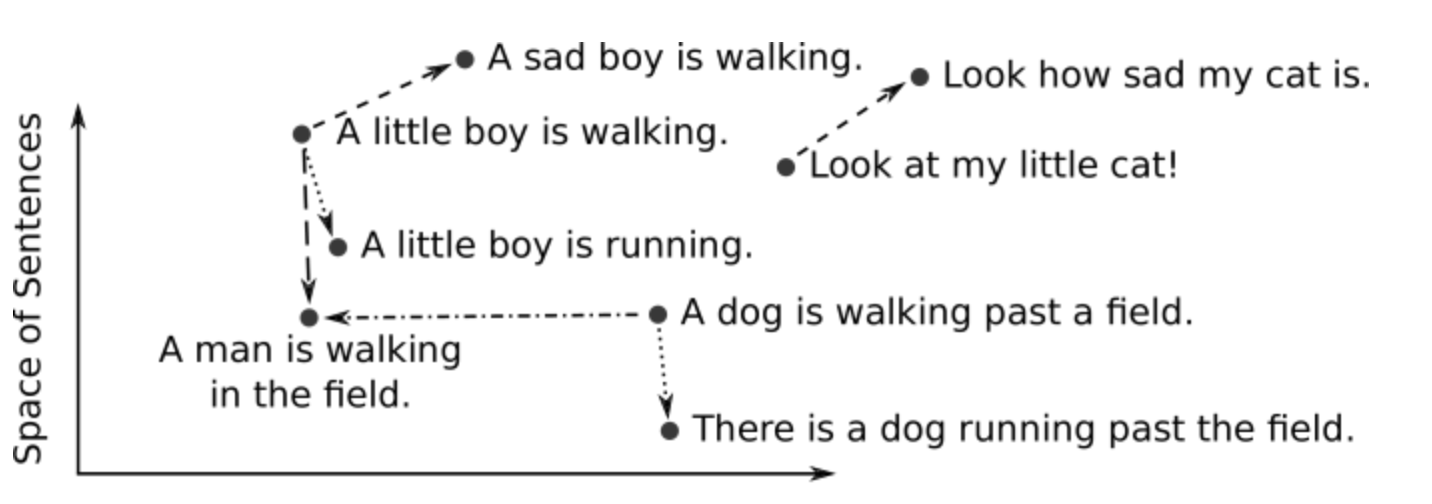

In [88]:
import openai
from pathlib import Path
import random
import time
import os

OPENAI_API_KEY = os.path.join(Path.cwd(), "openai_api_key.txt")
openai.api_key_path = os.path.join(Path.cwd(), OPENAI_API_KEY)

def get_embedding(text: str, model="text-embedding-ada-002") -> list[float]:
    return openai.Embedding.create(input=[text], model=model)["data"][0]["embedding"]




In [154]:
models = {}
for category in mlb.classes_:
    filename = f'model_rfc_{category}.joblib'
    try:
        with open(filename, 'rb') as file:
            models[category] = joblib.load(file)
        print(f"Model for {category} loaded successfully.")
    except FileNotFoundError:
        print(f"Model file {filename} not found.")
    except Exception as e:
        print(f"Error loading model file {filename}: {str(e)}")

print("Size of models dictionary:", len(models))
print("Categories in models dictionary:", list(models.keys()))

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    df['update_date'] = pd.to_datetime(df['update_date'])
    selected_rows = df[(df['update_date'] < pd.Timestamp('2020-01-01')) & (df['update_date'] > pd.Timestamp('2019-01-01'))].head(10)
    new_df = pd.DataFrame()
    new_df['title'] = selected_rows['title']
    new_df['abstract'] = selected_rows['abstract']
    new_df['context'] = selected_rows.apply(lambda row: f"{row['title']}\n{row['abstract']}", axis=1)
    new_df['embedding'] = new_df['context'].apply(get_embedding)
    new_df['true_labels'] = selected_rows["categories"].str.split(' ').apply(lambda x: [a.split('.')[0] for a in x])
    new_df.reset_index(inplace=True, drop = True)

    return new_df

def predict_labels(input_data: pd.DataFrame, threshold=0.1):
    predicted_labels = []

    for index, row in input_data.iterrows():
        labels = []
        for category, model in models.items():
            embedding = get_embedding(row['context'])
            proba = model.predict_proba([embedding])[0][1]

            if proba >= threshold:
                labels.append(category)

        predicted_labels.append(labels)


    comparison_df = input_data[['context', 'true_labels']].copy()
    comparison_df['predicted_labels'] = pd.Series(predicted_labels)

    return comparison_df

    

Model for astro-ph loaded successfully.
Model for cond-mat loaded successfully.
Model for cs loaded successfully.
Model for econ loaded successfully.
Model for eess loaded successfully.
Model for gr-qc loaded successfully.
Model for hep-ex loaded successfully.
Model for hep-lat loaded successfully.
Model for hep-ph loaded successfully.
Model for hep-th loaded successfully.
Model for math loaded successfully.
Model for math-ph loaded successfully.
Model for nlin loaded successfully.
Model for nucl-ex loaded successfully.
Model for nucl-th loaded successfully.
Model for physics loaded successfully.
Model for q-bio loaded successfully.
Model for q-fin loaded successfully.
Model for quant-ph loaded successfully.
Model for stat loaded successfully.
Size of models dictionary: 20
Categories in models dictionary: ['astro-ph', 'cond-mat', 'cs', 'econ', 'eess', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math', 'math-ph', 'nlin', 'nucl-ex', 'nucl-th', 'physics', 'q-bio', 'q-fin', 'quant-p

In [147]:
test_data = preprocess_data(df_all)
test_data

title   
0  Remnant evolution after a carbon-oxygen white ...  \
1  Cofibrations in the Category of Frolicher Spac...   
2  Torsional oscillations of longitudinally inhom...   
3  On the Energy-Momentum Problem in Static Einst...   
4  The Formation of Globular Cluster Systems in M...   
5  Photoproduction of pi0 omega off protons for E...   
6  Geometric Phase and Superconducting Flux Quant...   
7  Construction of Complete Embedded Self-Similar...   
8  Measurement of D0-D0bar mixing in D0->Ks pi+ p...   
9  Outflow and Infall in a Sample of Massive Star...   

                                            abstract   
0    We systematically explore the evolution of t...  \
1    Cofibrations are defined in the category of ...   
2    We explore the effect of an inhomogeneous ma...   
3    This paper has been removed by arXiv adminis...   
4    The most massive elliptical galaxies show a ...   
5    Differential and total cross-sections for ph...   
6    In a ring of s-wave superconducting material...   
7    We study the Dirichlet problem associated to...   
8    We report a measurement of D0-D0bar mixing i...   
9    We present single pointing observations of S...   

                                             context   
0  Remnant evolution after a carbon-oxygen white ...  \
1  Cofibrations in the Category of Frolicher Spac...   
2  Torsional oscillations of longitudinally inhom...   
3  On the Energy-Momentum Problem in Static Einst...   
4  The Formation of Globular Cluster Systems in M...   
5  Photoproduction of pi0 omega off protons for E...   
6  Geometric Phase and Superconducting Flux Quant...   
7  Construction of Complete Embedded Self-Similar...   
8  Measurement of D0-D0bar mixing in D0->Ks pi+ p...   
9  Outflow and Infall in a Sample of Massive Star...   

                                           embedding true_labels  
0  [-0.0066812713630497456, -0.011896345764398575...  [astro-ph]  
1  [-0.0053628478199243546, 0.004645234439522028,...      [math]  
2  [-0.01382253598421812, 0.018493041396141052, -...  [astro-ph]  
3  [-0.002806461649015546, -0.012942657805979252,...     [gr-qc]  
4  [-0.019961485639214516, 0.0007249642512761056,...  [astro-ph]  
5  [-0.004825817421078682, -0.032180968672037125,...   [nucl-ex]  
6  [-0.001585527090355754, 0.010833007283508778, ...  [quant-ph]  
7  [-0.000670253240969032, 0.015036219730973244, ...      [math]  
8  [-0.01069781556725502, 0.0004215358931105584, ...    [hep-ex]  
9  [-0.0020535083021968603, 0.027760647237300873,...  [astro-ph]

In [155]:
comparison_df = predict_labels(test_data)
comparison_df


context true_labels   
0  Remnant evolution after a carbon-oxygen white ...  [astro-ph]  \
1  Cofibrations in the Category of Frolicher Spac...      [math]   
2  Torsional oscillations of longitudinally inhom...  [astro-ph]   
3  On the Energy-Momentum Problem in Static Einst...     [gr-qc]   
4  The Formation of Globular Cluster Systems in M...  [astro-ph]   
5  Photoproduction of pi0 omega off protons for E...   [nucl-ex]   
6  Geometric Phase and Superconducting Flux Quant...  [quant-ph]   
7  Construction of Complete Embedded Self-Similar...      [math]   
8  Measurement of D0-D0bar mixing in D0->Ks pi+ p...    [hep-ex]   
9  Outflow and Infall in a Sample of Massive Star...  [astro-ph]   

                            predicted_labels  
0                                 [astro-ph]  
1                                 [cs, math]  
2        [astro-ph, cond-mat, math, physics]  
3                       [astro-ph, cs, math]  
4                                 [astro-ph]  
5  [hep-ex, math, nucl-ex, nucl-th, physics]  
6                 [cond-mat, math, quant-ph]  
7                                 [cs, math]  
8                               [cs, hep-ex]  
9                             [astro-ph, cs]

In [156]:
from sklearn.metrics import hamming_loss

hamming_loss(y_test[:, i], prediction)

0.08118376324735053